# Analysis of Access to Health Care using openrouteservice - Kano
> Note: All notebooks need the [environment dependencies](https://github.com/GIScience/openrouteservice-examples#local-installation)
> as well as an [openrouteservice API key](https://openrouteservice.org/dev/#/signup) to run

prepare environment dependencies document

## Abstract
The rapid growth of urban areas has put substantial pressure on local services and infrastructure, particularly in African cities. With migrants moving into cities and transient households moving within cities, traditional means of collecting data (e.g., censuses and household surveys) are inadequate and often overlook informal settlements and households. As a consequence, there is a chronic lack of basic data about deprived households and entire settlements. Given that urban poor residents rely predominantly on private and informal service providers for healthcare and other services, they are rarely captured in routine service data, including health information management systems. This is especially true for women and young people who often work in the informal sector. 

In this example we will focus on access to healthcare of slum areas in Lagos (Nigeria) , Kano (Nigeria), and Nairobi (Kenya).Quantifying and visualizing such inequalities is the aim of this notebook.

The notebook gives an overview on health sites distribution in these three cities and the barriers with access to those by foot and by car. Open source data from OpenStreetMap and research ([Macharia, P.M. et al., 2023](https://doi.org/10.1038/s41597-023-02651-9)) were used to create accessibility walking and driving isochrones for each healthcare facility. Spatial join analysis was employed to integrate 100x100m grid cells with the isochrone layers, categorizing the barriers to healthcare access into three levels: low, medium, and high.


### Workflow:
* **Preprocessing**: Get data for district boundaries, slum areas (100x100m grid cells) and health facilities.
* **Analysis**:
    * Compute accessibility to health care facilities using openrouteservice API
    * Spatial join 100x100m grid cells with isochrone layers.
* **Result**: Visualize results as maps.


### Datasets and Tools:
* [Shapefile of district boundaries][boundaries] - Admin Level 2 (data from Humanitarian Data Exchange, 25/11/2015)
* [Datasets of health facilities][facilities] (15/07/2023)
* [openrouteservice][ors] - generate isochrones on the OpenStreetMap road network

[boundaries]: https://data.humdata.org/dataset/nigeria-admin-level-2
[facilities]: https://doi.org/10.6084/m9.figshare.22689667.v2
[ors]: https://openrouteservice.org/

# Python Workflow

This study integrates various Python geospatial analysis libraries and packages to support spatial data processing, visualization, and isochrone generation. The os module is used to interact with the operating system, managing file paths and reading environment variables such as API keys. folium library along with its MarkerCluster plugin, facilitates the creation of interactive maps for visualizing large-scale geospatial data. The openrouteservice.client serves as an interface to the OpenRouteService API, enabling the extraction of isochrones. pandas library for data analysis, provides functions for analyzing, cleaning, exploring, and manipulating data, while fiona supports reading and writing real-world data using multi-layered GIS formats, such as shapefiles. The shapely package is employed for the manipulation and analysis of planar geometric objects.

## Setting up the virtual environment

```bash
# Create a new virtual environment
python -m venv .venv
activate .venv/bin/activate
pip install -r requirements.txt
```

## To run your notebook in VS Code

```bash
pip install -U ipykernel
python -m ipykernel install --user --name=.venv
```

In [2]:
import os
from IPython.display import display
import requests

import folium
from folium.plugins import MarkerCluster
import openrouteservice
import time

import pandas as pd
import numpy as np
import fiona as fn
import geopandas as gpd
from shapely.geometry import shape, mapping
from shapely.geometry import Point
from shapely.geometry import box

import math

from pathlib import Path
from shapely.geometry import Polygon

import seaborn as sns

## Preprocessing
In this study, users first requested an API key from the [OpenRouteService](https://openrouteservice.org/) platform and subsequently interacted with the OpenRouteService API through the instantiation of the OpenRouteService client. This is the OpenRouteService [API documentation](https://openrouteservice.org/dev/#/api-docs/introduction) for ORS Core-Version 9.0.0. 

Generate a [API Key](https://openrouteservice.org/dev/#/home?tab=1) (Token) it is necessary to sign up at the OpenRouteService dashboard by using your E-mail address or sign up with your GitHub. After logging in, go to the Dashboard by clicking on your profile icon and navigate to the API Keys section. Click "Create API Key" to generate a free key and then choose a service plan (the free plan has limited requests per day). Copy the API Key and store it securely. 

OpenRouteService primarily uses API keys for authentication. However, if a token is required for certain endpoints, you can send a request with your API key in the Authorization header. This process facilitated various geospatial analysis functions, including isochrone generation.



### Setting up the OSR API and the public endpoint
Make sure you have a .env file in the root directory with the following content:
```bash
    OPENROUTESERVICE_API_KEY='your_api_key'
```

In [1]:
# Read the api key from the .env file
from dotenv import load_dotenv
%load_ext dotenv
%dotenv
api_key = os.getenv('OPENROUTESERVICE_API_KEY')
ors = client.Client(key=api_key)

cannot find .env file


NameError: name 'os' is not defined

In [4]:
import openrouteservice
api_key = 'your_api_key_here'  # Replace with your actual API key
ors = openrouteservice.Client(key=api_key)

### Setting up the OSR using a local instance for the service

You must have set up the OpenRouteService API locally. You can find the instructions in the [OpenRouteService documentation](https://openrouteservice.org/dev/).

In [6]:
import openrouteservice
base_url = 'http://localhost:8022/ors'
ors = openrouteservice.Client(base_url=base_url)

For this study different kind of data were used. The dataset on healthcare facilities is sourced from a research [GRID3 NGA - Health Facilities v2.0](https://data.grid3.org/datasets/a0ed9627a8b240ff8b315a84575754a4_0/explore) which provides A geospatial database of close-to-reality travel times to obstetric emergency care in 15 Nigerian conurbations. The dataset were filtered by state name to isolate facilities in Kano and converted CSV file to shapefile based on coordinates using [QGIS](https://qgis.org/). 

The Level 2 administrative boundary data is sourced from [Humanitarian Data Exchange](https://data.humdata.org/) were used to correlate the isochrones and healthcare facility distribution with specific administrative regions. The data were filtered based on the administrative region name (lganame) to focus the analysis on Kano.

* [Datasets of health facilities](https://data.grid3.org/datasets/a0ed9627a8b240ff8b315a84575754a4_0/explore) (15/07/2023)
* [Shapefile of district boundaries](https://data.humdata.org/dataset/nigeria-admin-level-2) - Admin Level 2 (data from Humanitarian Data Exchange, 25/11/2015)

### Setting up folde structure for inputs, temp and outputs folders - Option 1: Kano
If you want to process data for the city of Kano, use the following code to filter the dataset. 

In [56]:
# Set paths to access Kano data
# Define directories
data_inputs = '../scripts/Kano/data-inputs/'
data_temp = '../scripts/Kano/data-temp/'
model_outputs = '../Kano-v2/'

### Setting up folde structure for inputs, temp and outputs folders - Option 2: Lagos
If you want to process data for the city of Kano, use the following code to filter the dataset. 

In [7]:
# Set paths to access Lagos data
# Define directories
data_inputs = '../scripts/Lagos/data-inputs/'
data_temp = '../scripts/Lagos/data-temp/'
model_outputs = '../Lagos-v2/'

## Data Collection

### 1.1 Study area and Administrative level 2

In [8]:
study_area = gpd.read_file(data_inputs + '100mGrid.gpkg')
districts = gpd.read_file(data_inputs + 'administrative_level2.geojson')

In [9]:
# Adding a grid_id to the gridcells in the study area
study_area['grid_id'] = range(len(study_area))

### 2.1 Validated healthcare facilities
note: to describe the process to validate healthcare facilities
Due to the absence of local expert validation, the classification for validation is determine based on the ownership provided in the [GRID3 NGA - Health Facilities v2.0](https://data.grid3.org/datasets/a0ed9627a8b240ff8b315a84575754a4_0/explore).

### Option 1: Kano

In [6]:
healthcare_facilities_validated = gpd.read_file(data_inputs + 'healthcare_facilities.geojson')
healthcare_facilities_validated

DataSourceError: ../scripts/Lagos/data-inputs/healthcare_facilities.geojson: No such file or directory

In [24]:
print(healthcare_facilities_validated['ownership'].unique())

['Public' 'Private' 'Unknown']


In [25]:
facilities = healthcare_facilities_validated[
    healthcare_facilities_validated['ownership'].isin(['Public', 'Unknown'])]

facilities



,OBJECTID,globalid,nhfr_uid,nhfr_facility_code,country,iso,state,lga,lga_name_disagreement,ward,...,facility_level,facility_level_option,latitude,longitude,geocoordinates_source,last_updated,x,y,Local Validation,geometry
0,4345,a4df570b-3847-4804-b003-76b63118d3d3,79025491.0,19/20/1/1/1/0005,Nigeria,NGA,Kano,Kabo,False,Dugabau,...,Primary,Primary Health Clinic,11.802710,8.207114,GRID3_EHEALTH,11/11/2024,8.207114,11.802710,Primary,POINT (8.20711 11.80271)
1,4346,f7f13dbc-3aa9-44a7-ab82-3c02acd49328,85019835.0,19/28/1/1/1/0030,Nigeria,NGA,Kano,Madobi,False,Kubarachi,...,Primary,Primary Health Clinic,11.851540,8.393390,GRID3_EHEALTH,11/11/2024,8.393390,11.851540,Primary,POINT (8.39339 11.85154)
2,4347,8aa79a78-d62c-4359-a8e7-6adf4a5eaeaf,21927961.0,19/35/1/1/1/0018,Nigeria,NGA,Kano,Shanono,False,Leni,...,Primary,Primary Health Center,12.002650,8.097110,GRID3_EHEALTH,11/11/2024,8.097110,12.002650,Primary,POINT (8.09711 12.00265)
3,4349,72f32874-0616-4216-b800-c1249be8897f,47773193.0,19/18/1/1/1/0005,Nigeria,NGA,Kano,Gezawa,False,Ketawa,...,Primary,Primary Health Clinic,12.048380,8.743630,NHFR_2024,11/11/2024,8.743630,12.048380,Primary,POINT (8.74363 12.04838)
4,4348,48799221-012c-4427-9e10-8ddd5f053d46,36342440.0,19/04/1/1/1/0003,Nigeria,NGA,Kano,Bebeji,False,Rahama,...,Primary,Health Post,11.427942,8.310408,GRID3_EHEALTH,11/11/2024,8.310408,11.427942,Primary,POINT (8.31041 11.42794)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711,50565,7d72d158-152c-4ff8-b147-13107a1d1729,14600085.0,19/11/1/1/1/0017,Nigeria,NGA,Kano,Doguwa,False,Tagwaye,...,Primary,Health Post,10.803460,8.654490,NHFR_2024,11/11/2024,8.654490,10.803460,Primary,POINT (8.65449 10.80346)
1718,50694,3784c3a4-3bbb-4eec-ae3c-2c16ed986ee9,85509423.0,19/42/1/1/1/0031,Nigeria,NGA,Kano,Ungogo,False,Karo,...,Primary,Health Post,12.121400,8.546450,NHFR_2024,11/11/2024,8.546450,12.121400,Primary,POINT (8.54645 12.1214)
1719,49845,0fef3a7f-89b8-42c0-9e94-6246304e1185,56766218.0,19/17/1/2/1/0002,Nigeria,NGA,Kano,Gwale,False,Dorayi,...,Secondary,Unknown,11.975480,8.467010,NHFR_2024,11/11/2024,8.467010,11.975480,Secondary/Tertiary,POINT (8.46701 11.97548)
1720,50696,8a7b3cd1-5dac-45ee-9a75-ca6427bdb504,12808453.0,19/42/1/1/1/0032,Nigeria,NGA,Kano,Ungogo,False,Fanisau,...,Primary,Health Post,12.082840,8.516740,NHFR_2024,11/11/2024,8.516740,12.082840,Primary,POINT (8.51674 12.08284)


In [26]:
facilities = facilities.reset_index(drop=True)
facilities['hcf_id'] = facilities.index + 1
facilities

,OBJECTID,globalid,nhfr_uid,nhfr_facility_code,country,iso,state,lga,lga_name_disagreement,ward,...,facility_level_option,latitude,longitude,geocoordinates_source,last_updated,x,y,Local Validation,geometry,hcf_id
0,4345,a4df570b-3847-4804-b003-76b63118d3d3,79025491.0,19/20/1/1/1/0005,Nigeria,NGA,Kano,Kabo,False,Dugabau,...,Primary Health Clinic,11.802710,8.207114,GRID3_EHEALTH,11/11/2024,8.207114,11.802710,Primary,POINT (8.20711 11.80271),1
1,4346,f7f13dbc-3aa9-44a7-ab82-3c02acd49328,85019835.0,19/28/1/1/1/0030,Nigeria,NGA,Kano,Madobi,False,Kubarachi,...,Primary Health Clinic,11.851540,8.393390,GRID3_EHEALTH,11/11/2024,8.393390,11.851540,Primary,POINT (8.39339 11.85154),2
2,4347,8aa79a78-d62c-4359-a8e7-6adf4a5eaeaf,21927961.0,19/35/1/1/1/0018,Nigeria,NGA,Kano,Shanono,False,Leni,...,Primary Health Center,12.002650,8.097110,GRID3_EHEALTH,11/11/2024,8.097110,12.002650,Primary,POINT (8.09711 12.00265),3
3,4349,72f32874-0616-4216-b800-c1249be8897f,47773193.0,19/18/1/1/1/0005,Nigeria,NGA,Kano,Gezawa,False,Ketawa,...,Primary Health Clinic,12.048380,8.743630,NHFR_2024,11/11/2024,8.743630,12.048380,Primary,POINT (8.74363 12.04838),4
4,4348,48799221-012c-4427-9e10-8ddd5f053d46,36342440.0,19/04/1/1/1/0003,Nigeria,NGA,Kano,Bebeji,False,Rahama,...,Health Post,11.427942,8.310408,GRID3_EHEALTH,11/11/2024,8.310408,11.427942,Primary,POINT (8.31041 11.42794),5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,50565,7d72d158-152c-4ff8-b147-13107a1d1729,14600085.0,19/11/1/1/1/0017,Nigeria,NGA,Kano,Doguwa,False,Tagwaye,...,Health Post,10.803460,8.654490,NHFR_2024,11/11/2024,8.654490,10.803460,Primary,POINT (8.65449 10.80346),1498
1498,50694,3784c3a4-3bbb-4eec-ae3c-2c16ed986ee9,85509423.0,19/42/1/1/1/0031,Nigeria,NGA,Kano,Ungogo,False,Karo,...,Health Post,12.121400,8.546450,NHFR_2024,11/11/2024,8.546450,12.121400,Primary,POINT (8.54645 12.1214),1499
1499,49845,0fef3a7f-89b8-42c0-9e94-6246304e1185,56766218.0,19/17/1/2/1/0002,Nigeria,NGA,Kano,Gwale,False,Dorayi,...,Unknown,11.975480,8.467010,NHFR_2024,11/11/2024,8.467010,11.975480,Secondary/Tertiary,POINT (8.46701 11.97548),1500
1500,50696,8a7b3cd1-5dac-45ee-9a75-ca6427bdb504,12808453.0,19/42/1/1/1/0032,Nigeria,NGA,Kano,Ungogo,False,Fanisau,...,Health Post,12.082840,8.516740,NHFR_2024,11/11/2024,8.516740,12.082840,Primary,POINT (8.51674 12.08284),1501


### Option 2: Lagos

Considering the study area defined for Lagos, the selection of healthcare facilities relied on the intersection of the boundaries of our study area ([see the documentation about IDEAMAPS study areas](../../../docs/study-areas/README.md)).  

In [10]:
healthcare_facilities = gpd.read_file(data_inputs + 'GRID3_NGA_healthcare_facilities.geojson')
healthcare_facilities

,OBJECTID,globalid,nhfr_uid,nhfr_facility_code,country,iso,state,lga,lga_name_disagreement,ward,...,ownership_type,facility_level,facility_level_option,latitude,longitude,geocoordinates_source,last_updated,x,y,geometry
0,1,9c2b58dd-1e99-49b9-970e-eabce1c7dd10,57132712.0,08/07/1/1/1/0030,Nigeria,NGA,Borno,Damboa,False,Gumsuri,...,Local Government,Primary,Primary Health Center,11.059840,12.808550,NHFR_2024,11/11/2024,12.808550,11.059840,POINT (12.80855 11.05984)
1,2,5a3864b5-d66b-4683-90cd-9c76af393450,42800186.0,08/02/1/1/1/0044,Nigeria,NGA,Borno,Askira/Uba,False,Uba,...,Local Government,Primary,Primary Health Center,10.458997,13.213818,GRID3_EHEALTH,11/11/2024,13.213818,10.458997,POINT (13.21382 10.459)
2,3,cfe845eb-9f71-4b99-9603-d2f389a73ba0,26934297.0,08/02/1/1/1/0034,Nigeria,NGA,Borno,Askira/Uba,False,Ngulde,...,Local Government,Primary,Primary Health Center,10.632343,12.545808,GRID3_EHEALTH,11/11/2024,12.545808,10.632343,POINT (12.54581 10.63234)
3,4,0fcbdf4a-8ea2-4df9-9167-4c9f1377f27c,43109689.0,08/06/1/1/1/0021,Nigeria,NGA,Borno,Chibok,False,Shikarkir,...,Local Government,Primary,Primary Health Center,10.802780,12.776800,GRID3_EHEALTH,11/11/2024,12.776800,10.802780,POINT (12.7768 10.80278)
4,5,12c47bd1-535e-4de7-9cad-ad34f43b1965,28489340.0,08/06/1/1/1/0025,Nigeria,NGA,Borno,Chibok,False,Kuburmbula,...,Local Government,Primary,Health Post,10.888690,12.903770,GRID3_EHEALTH,11/11/2024,12.903770,10.888690,POINT (12.90377 10.88869)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51017,51018,d776c062-fc18-4403-99d9-ad325cc536c7,15188853.0,36/14/1/1/1/0066,Nigeria,NGA,Zamfara,Zurmi,False,Rukudawa,...,Local Government,Primary,Unknown,12.742050,6.761610,NHFR_2024,11/11/2024,6.761610,12.742050,POINT (6.76161 12.74205)
51018,51019,46998eb7-c4cc-4a0f-940c-07d429eac842,16821413.0,36/14/1/1/1/0019,Nigeria,NGA,Zamfara,Zurmi,False,Boko,...,Local Government,Primary,Health Post,12.756730,6.561510,NHFR_2024,11/11/2024,6.561510,12.756730,POINT (6.56151 12.75673)
51019,51020,3d4909fb-8fdf-419b-bc1c-f6dbdc6d6c2d,32039607.0,36/14/1/1/1/0064,Nigeria,NGA,Zamfara,Zurmi,False,Mayasa Kuturu,...,Local Government,Primary,Health Post,12.864518,6.761610,NHFR_2024,11/11/2024,6.761610,12.864518,POINT (6.76161 12.86452)
51020,51021,52e13068-c307-489f-909e-806ffc826aaf,85934103.0,28/01/1/1/1/0016,Nigeria,NGA,Ondo,Ile-Oluji/Okeigbo,False,Ile-Oluji 6,...,Unknown,Primary,Unknown,7.201210,4.862570,NHFR_2024,11/11/2024,4.862570,7.201210,POINT (4.86257 7.20121)


In [11]:
# Selection of healthcare faclities inside the study area
healthcare_facilities = gpd.sjoin(healthcare_facilities, study_area, how="inner", predicate="intersects")
healthcare_facilities

,OBJECTID,globalid,nhfr_uid,nhfr_facility_code,country,iso,state,lga,lga_name_disagreement,ward,...,index_right,id,rowid,latitude_right,lat_min,lat_max,longitude_right,lon_min,lon_max,grid_id
150,151,d34b8933-7c5c-45e6-a59e-f8108b3a8e58,62363642.0,24/11/1/1/2/0020,Nigeria,NGA,Lagos,Ikeja,False,Orile Ikeja,...,175867,146663750.0,175868,6.598262,6.597856,6.598667,3.349775,3.349273,3.350278,175867
152,153,609a7503-3d0a-4e48-93b7-20ba8f399a11,72639392.0,27/18/1/1/1/0015,Nigeria,NGA,Ogun,Sagamu,False,Simawa,...,255285,149226305.0,255286,6.774224,6.773818,6.774629,3.501837,3.501334,3.502340,255285
179,180,f7d08239-f814-4d6d-a42f-88edd0c84d60,87002379.0,24/10/1/1/2/0003,Nigeria,NGA,Lagos,Ifako/Ijaye,False,Iju Ishaga,...,161921,146171476.0,161922,6.667995,6.667590,6.668400,3.321011,3.320508,3.321514,161921
186,187,d03f0f95-d6fc-4d9b-b3b6-f5cfa93e9894,22329609.0,24/02/1/2/2/0004,Nigeria,NGA,Lagos,Ajeromi/Ifelodun,False,Amukoko,...,170891,146477223.0,170892,6.464482,6.464076,6.464887,3.338204,3.337702,3.338707,170891
370,371,9b801390-a76d-4c2c-9845-3502ddb6bed2,55304011.0,24/14/1/1/1/0008,Nigeria,NGA,Lagos,Lagos Island,False,Idumoyinbo,...,196361,147393713.0,196362,6.462860,6.462455,6.463266,3.392290,3.391787,3.392792,196361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50892,50893,36ac306d-a11b-4ce5-95cd-dd15d5e2808a,84680652.0,27/05/1/1/2/0005,Nigeria,NGA,Ogun,Ifo,False,Oke-Aro / Ibaragun,...,160380,146120497.0,160381,6.719081,6.718676,6.719487,3.318219,3.317717,3.318722,160380
50896,50897,1563298b-98d9-4a8e-854d-dedef9cd7168,38886226.0,27/13/1/2/2/0007,Nigeria,NGA,Ogun,Obafemi Owode,False,Ofada,...,194932,147359445.0,194933,6.725568,6.725163,6.725974,3.391395,3.390893,3.391898,194932
50897,50898,61c2af19-0d8b-4772-b615-069e668bb541,34035069.0,27/13/1/1/2/0018,Nigeria,NGA,Ogun,Obafemi Owode,False,Owode Imuagun,...,210626,147834597.0,210627,6.777468,6.777062,6.777873,3.419679,3.419176,3.420182,210626
50898,50899,cd92e8d0-879a-47ac-a4f9-efd3cd888f33,29097344.0,27/18/1/1/2/0015,Nigeria,NGA,Ogun,Sagamu,False,Ogijo,...,273897,149837309.0,273898,6.764493,6.764087,6.764898,3.537868,3.537365,3.538371,273897


In [12]:
print(healthcare_facilities['ownership'].unique())

['Private' 'Public' 'Unknown']


Since local validation of the healthcare facilities was not possible for the Kano study area, the classfication of facilities offering general healthcare was made based on the ownership provided in the GRID3 NGA - Health Facilities v2.0 dataset.
- Public: For those where the ownership was reported.
- Unknown: To not exclude facilities potentially offering general healthcare in slums or other deprived areas. 

In [17]:

facilities = healthcare_facilities[
    healthcare_facilities['ownership'].isin(['Public', 'Unknown'])]
facilities

,OBJECTID,globalid,nhfr_uid,nhfr_facility_code,country,iso,state,lga,lga_name_disagreement,ward,...,index_right,id,rowid,latitude_right,lat_min,lat_max,longitude_right,lon_min,lon_max,grid_id
152,153,609a7503-3d0a-4e48-93b7-20ba8f399a11,72639392.0,27/18/1/1/1/0015,Nigeria,NGA,Ogun,Sagamu,False,Simawa,...,255285,149226305.0,255286,6.774224,6.773818,6.774629,3.501837,3.501334,3.502340,255285
370,371,9b801390-a76d-4c2c-9845-3502ddb6bed2,55304011.0,24/14/1/1/1/0008,Nigeria,NGA,Lagos,Lagos Island,False,Idumoyinbo,...,196361,147393713.0,196362,6.462860,6.462455,6.463266,3.392290,3.391787,3.392792,196361
392,393,69b5f5cb-01cb-4eb5-9fb6-a2585b50ea60,30590019.0,24/17/1/1/1/0010,Nigeria,NGA,Lagos,Ojo,False,Irewe,...,56234,143201684.0,56235,6.418270,6.417865,6.418675,3.144697,3.144195,3.145199,56234
446,447,502200ac-0b5b-4483-98d2-5bbec6ccf147,75985784.0,24/12/1/1/1/0019,Nigeria,NGA,Lagos,Ikorodu,False,Olorunda 13,...,294658,150652083.0,294659,6.668806,6.668400,6.669211,3.585533,3.585031,3.586036,294658
490,491,e5c413b0-5c35-4eb2-8eaa-21c90a4fafc2,34682875.0,24/12/1/1/1/0018,Nigeria,NGA,Lagos,Ikorodu,False,Oke Eletu,...,295788,150703083.0,295789,6.600694,6.600289,6.601100,3.588233,3.587730,3.588736,295788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50778,50779,abaf6743-8b43-43a4-94a3-c1ce17ea8a6d,15075514.0,24/03/1/1/1/0022,Nigeria,NGA,Lagos,Alimosho,False,Mosan / Akinoggun,...,148058,145713301.0,148059,6.612046,6.611641,6.612451,3.293727,3.293224,3.294230,148058
50785,50786,65368266-2475-4d57-b836-e05f06264d68,62794907.0,24/04/1/1/1/0009,Nigeria,NGA,Lagos,Amuwo Odofin,False,Kirikiri,...,154635,145917173.0,154636,6.443403,6.442997,6.443808,3.305063,3.304560,3.305565,154635
50802,50803,ba7dd65d-3566-4f79-943b-5ebbc0170bad,68751732.0,24/13/1/1/2/0025,Nigeria,NGA,Lagos,Kosofe,False,Bamgbe/Elebiju Ward,...,194541,147342634.0,194542,6.595018,6.594613,6.595424,3.389837,3.389334,3.390339,194541
50813,50814,4684216f-c27b-469b-aa1e-288efa27a1fd,84113737.0,24/20/1/2/1/0112,Nigeria,NGA,Lagos,Surulere,False,Muniru Baruwa,...,175513,146646887.0,175514,6.509884,6.509479,6.510290,3.348407,3.347905,3.348910,175513


In [19]:
facilities = facilities.reset_index(drop=True)
facilities['hcf_id'] = facilities.index + 1


### Create district dictionary and facilities dictionary
In conducting geospatial analysis, we created dictionaries containing district information and healthcare facility information to achieve efficient data management and subsequent analysis.

In [20]:
# these files will be generated during processing
isochrones_car_filename = data_temp + 'iso_union_car.shp'
isochrones_car_per_district_filename = data_temp + 'iso_car_per_district.shp'
isochrones_foot_filename = data_temp + 'iso_union_foot.shp'
isochrones_foot_per_district_filename = data_temp + 'iso_foot_per_district.shp'

# final file with all generated information
output_file = data_temp + 'districts_final.geojson'

In [21]:
districts_dictionary = {}
for _, feature in districts.iterrows():
    district_id = int(feature['OBJECTID'])
    districts_dictionary[district_id] = {
        'District Code': feature['LGACode'],
        'District Name': feature['LGAName'],
        'geometry': feature['geometry']
    }
print(f'created dictionary for {len(districts_dictionary)} districts')

facilities_dictionary = {}
for _, feature in facilities.iterrows():
    facility_id = int(feature['hcf_id'])
    facilities_dictionary[facility_id] = {
        'geometry': feature['geometry']
    }
print(f'created dictionary for {len(facilities_dictionary)} facilities')

created dictionary for 20 districts
created dictionary for 1016 facilities


### An overview and look at a map of the districts and health facilities
First a map were created with [Folium](https://python-visualization.github.io/folium/latest/) to visualize data manipulated in Python. The boundaries of the districts as well as the health sites were given as shapefiles, which were printed on the map. 

In [29]:
map_outline = folium.Map(tiles='Stamen Toner', location=[-18.812718, 46.713867], zoom_start=5, attr='Map tiles by Stamen Design, CC BY 3.0 — Map data © OpenStreetMap contributors')

# Import health facilities
cluster = MarkerCluster().add_to(map_outline)  # To cluster hospitals

for facility_id in facilities_dictionary:
    folium.Marker(list(reversed(facilities_dictionary[facility_id]['geometry'].coords[0]))).add_to(cluster)

# Import district boundaries
district_simp = []  # Initialize the list
for district_id in districts_dictionary:
    geom = shape(districts_dictionary[district_id]['geometry'])
    # we simplify the geometry just for the purpose of visualisation
    # be aware that some browsers e.g. chrome might fail to render the entire map if there are to many coordinates
    simp_geom = geom.simplify(0.005, preserve_topology=False)
    simp_coord = mapping(simp_geom)
    folium.GeoJson(simp_coord).add_to(map_outline)
    district_simp.append(simp_coord)

#change to variable
map_outline.save(os.path.join(data_temp + 'healthcare_facilities_overview.html'))
map_outline

## Analysis
We will follow these steps:
* Get Isochrones from openrouteservice
* Perform Spatial Join
* Save output as GeoPackage file and CSV file

### Get Isochrones from OpenRouteService
Due to the limited road networks in the slum areas of these three cities, the accessibility of hospitals within a 10-minute range is of significant concern. Therefore, isochrones with 15 minutes walk range and 10 minutes car drive range around each hospital were created with the open source tool [OpenRouteService](https://openrouteservice.org/). This might take several minutes depending on the number of health facilities (currently we can send 40 requests per minute).

## Option 1: Kano

In [30]:
print(facilities['Local Validation'].unique())

['Primary' 'Secondary/Tertiary']


### 1. Calculating the isochrones for 10 minute driving

In [37]:
all_features = []

# Initialize request counter
request_counter = 0

# Create a dictionary to store isochrones by category
isochrones_by_category = {
    "Primary": [],
    "Secondary/Tertiary": []
}

# Loop through each category
for category in isochrones_by_category.keys():
    # Filter facilities by category
    group = facilities[facilities["Local Validation"] == category]

    for _, row in group.iterrows():
        loc = row["geometry"]
        facility_id = row["hcf_id"]
        facility_name = row["facility_name"]

        # Make sure geometry is a Point and get [lon, lat]
        if isinstance(loc, Point):
            coordinates = [loc.x, loc.y]
        else:
            print(f"Invalid geometry for: {row.get('facility_name', 'Unknown')} — Skipping")
            continue

        try:
            # Prepare request parameters
            iso_params = {
                "locations": [coordinates],
                "profile": "driving-car",
                "range_type": "distance",
                "range": [3300],  # 3.3km

                # "range": [600],  # 10 minutes
                # "attributes": ["area"]
            }

            # Request isochrone from ORS
            isochrone = ors.isochrones(**iso_params)

            for feature in isochrone['features']:
                properties = feature['properties']

                # Convert list fields to strings if needed
                for key, value in properties.items():
                    if isinstance(value, list):
                        properties[key] = ', '.join(map(str, value))

                # Add a new column for the category
                properties["Local Validation"] = category
                properties["facility_id"] = facility_id
                properties["facility_name"] = facility_name

                all_features.append({
                    'geometry': feature['geometry'],
                    'properties': properties
                })

            # Handle rate limiting
            request_counter += 1
            if request_counter % 35 == 0:
                print("Pausing for 60 seconds to respect API rate limits...")
                # Use this sleep when using the OSR instance hosted by HeiGIT
                # # time.sleep(60)
            if request_counter > 2500:
                print("Reached max request threshold.")
                break

        except Exception as e:
            print(f"Request failed for {row.get('facility_name', 'Unknown')}: {e}")

Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate lim

In [38]:
# Convert to GeoDataFrame if there are valid features
if all_features:
    iso_gdf = gpd.GeoDataFrame.from_features(all_features, crs="EPSG:4326")

    # Ensure 'Local Validation' is a string column
    iso_gdf["Local Validation"] = iso_gdf["Local Validation"].astype(str)
    iso_gdf["facility_id"] = iso_gdf["facility_id"].astype(str)
    iso_gdf["facility_name"] = iso_gdf["facility_name"].astype(str)

    # Save to a single GeoPackage file
    iso_gdf.to_file(data_temp + 'General_healthcare_iso_3_3km_car.gpkg', driver="GPKG")
    

### 2. Calculating the isochrones for walking

In [42]:
all_features = []

# Initialize request counter
request_counter = 0

# Create a dictionary to store isochrones by category
isochrones_by_category = {
    "Primary": [],
    "Secondary/Tertiary": []
}

# Loop through each category
for category in isochrones_by_category.keys():
    # Filter facilities by category
    group = facilities[facilities["Local Validation"] == category]

    for _, row in group.iterrows():
        loc = row["geometry"]
        facility_id = row["hcf_id"]
        facility_name = row["facility_name"]

        # Make sure geometry is a Point and get [lon, lat]
        if isinstance(loc, Point):
            coordinates = [loc.x, loc.y]
        else:
            print(f"Invalid geometry for: {row.get('facility_name', 'Unknown')} — Skipping")
            continue

        try:
            # Prepare request parameters
            iso_params = {
                "locations": [coordinates],
                "profile": "driving-car",

                "range_type": "distance",
                "range": [1000],  # 1km

               # "range_type": "time",
               # "range": [900],  # 15 minutes

                "attributes": ["area"]
            }

            # Request isochrone from ORS
            isochrone = ors.isochrones(**iso_params)

            for feature in isochrone['features']:
                properties = feature['properties']

                # Convert list fields to strings if needed
                for key, value in properties.items():
                    if isinstance(value, list):
                        properties[key] = ', '.join(map(str, value))

                # Add a new column for the category
                properties["Local Validation"] = category
                properties["facility_id"] = facility_id
                properties["facility_name"] = facility_name

                all_features.append({
                    'geometry': feature['geometry'],
                    'properties': properties
                })

            # Handle rate limiting
            request_counter += 1
            if request_counter % 35 == 0:
                print("Pausing for 60 seconds to respect API rate limits...")
                # time.sleep(60)
            if request_counter > 2500:
                print("Reached max request threshold.")
                break

        except Exception as e:
            print(f"Request failed for {row.get('facility_name', 'Unknown')}: {e}")


Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate lim

In [43]:
# Convert to GeoDataFrame if there are valid features
if all_features:
    iso_gdf = gpd.GeoDataFrame.from_features(all_features, crs="EPSG:4326")

    # Ensure 'combination' is a string column
    iso_gdf["Local Validation"] = iso_gdf["Local Validation"].astype(str)
    iso_gdf["facility_id"] = iso_gdf["facility_id"].astype(str)
    iso_gdf["facility_name"] = iso_gdf["facility_name"].astype(str)

    # Save to a single GeoPackage file
    iso_gdf.to_file(data_temp + 'General_healthcare_iso_1km_walking.gpkg', driver="GPKG")

## Option 2: Lagos

In [23]:
print(facilities['facility_level'].unique())

['Primary' 'Secondary' 'Tertiary' 'Unknown']


### Calculating the isochrones for driving

In [24]:
all_features = []

# Initialize request counter
request_counter = 0

# Create a dictionary to store isochrones by category
isochrones_by_category = {
    "Primary": [],
    "Secondary": [],
    "Tertiary": [],
    "Unknown": []
}

# Loop through each category
for category in isochrones_by_category.keys():
    # Filter facilities by category
    group = facilities[facilities["facility_level"] == category]

    for _, row in group.iterrows():
        loc = row["geometry"]
        facility_id = row["hcf_id"]
        facility_name = row["facility_name"]

        # Make sure geometry is a Point and get [lon, lat]
        if isinstance(loc, Point):
            coordinates = [loc.x, loc.y]
        else:
            print(f"Invalid geometry for: {row.get('facility_name', 'Unknown')} — Skipping")
            continue

        try:
            # Prepare request parameters
            iso_params = {
                "locations": [coordinates],
                "profile": "driving-car",
                "range_type": "distance",
                "range": [3300],  # 3.3km

                # "range": [600],  # 10 minutes
                # "attributes": ["area"]
            }

            # Request isochrone from ORS
            isochrone = ors.isochrones(**iso_params)

            for feature in isochrone['features']:
                properties = feature['properties']

                # Convert list fields to strings if needed
                for key, value in properties.items():
                    if isinstance(value, list):
                        properties[key] = ', '.join(map(str, value))

                # Add a new column for the category
                properties["facility_level"] = category
                properties["facility_id"] = facility_id
                properties["facility_name"] = facility_name

                all_features.append({
                    'geometry': feature['geometry'],
                    'properties': properties
                })

            # Handle rate limiting
            request_counter += 1
            if request_counter % 35 == 0:
                print("Pausing for 60 seconds to respect API rate limits...")
                # Use this sleep when using the OSR instance hosted by HeiGIT
                # # time.sleep(60)
            if request_counter > 2500:
                print("Reached max request threshold.")
                break

        except Exception as e:
            print(f"Request failed for {row.get('facility_name', 'Unknown')}: {e}")

Request failed for Irewe Primary Health Center: 500 ({'error': {'code': 3099, 'message': 'Unable to build an isochrone map.'}, 'info': {'engine': {'build_date': '2025-01-27T14:57:38Z', 'graph_version': '1', 'version': '9.0.0'}, 'timestamp': 1747321081904}})
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Request failed for Irewe Irewe Bstop Irewe Ojo Lagos Health Center: 500 ({'error': {'code': 3099, 'message': 'Unable to build an isochrone map.'}, 'info': {'engine': {'build_date': '2025-01-27T14:57:38Z', 'graph_

In [25]:
# Convert to GeoDataFrame if there are valid features
if all_features:
    iso_gdf = gpd.GeoDataFrame.from_features(all_features, crs="EPSG:4326")

    # Ensure 'Local Validation' is a string column
    iso_gdf["facility_level"] = iso_gdf["facility_level"].astype(str)
    iso_gdf["facility_id"] = iso_gdf["facility_id"].astype(str)
    iso_gdf["facility_name"] = iso_gdf["facility_name"].astype(str)

    # Save to a single GeoPackage file
    iso_gdf.to_file(data_temp + 'General_healthcare_iso_3_3km_car.gpkg', driver="GPKG")

### Calculating the isochrones for walking

In [26]:
all_features = []

# Initialize request counter
request_counter = 0

# Create a dictionary to store isochrones by category
isochrones_by_category = {
    "Primary": [],
    "Secondary": [],
    "Tertiary": [],
    "Unknown": []
}

# Loop through each category
for category in isochrones_by_category.keys():
    # Filter facilities by category
    group = facilities[facilities["facility_level"] == category]

    for _, row in group.iterrows():
        loc = row["geometry"]
        facility_id = row["hcf_id"]
        facility_name = row["facility_name"]

        # Make sure geometry is a Point and get [lon, lat]
        if isinstance(loc, Point):
            coordinates = [loc.x, loc.y]
        else:
            print(f"Invalid geometry for: {row.get('facility_name', 'Unknown')} — Skipping")
            continue

        try:
            # Prepare request parameters
            iso_params = {
                "locations": [coordinates],
                "profile": "driving-car",

                "range_type": "distance",
                "range": [1000],  # 1km

               # "range_type": "time",
               # "range": [900],  # 15 minutes

                "attributes": ["area"]
            }

            # Request isochrone from ORS
            isochrone = ors.isochrones(**iso_params)

            for feature in isochrone['features']:
                properties = feature['properties']

                # Convert list fields to strings if needed
                for key, value in properties.items():
                    if isinstance(value, list):
                        properties[key] = ', '.join(map(str, value))

                # Add a new column for the category
                properties["facility_level"] = category
                properties["facility_id"] = facility_id
                properties["facility_name"] = facility_name

                all_features.append({
                    'geometry': feature['geometry'],
                    'properties': properties
                })

            # Handle rate limiting
            request_counter += 1
            if request_counter % 35 == 0:
                print("Pausing for 60 seconds to respect API rate limits...")
                # time.sleep(60)
            if request_counter > 2500:
                print("Reached max request threshold.")
                break

        except Exception as e:
            print(f"Request failed for {row.get('facility_name', 'Unknown')}: {e}")


Request failed for Irewe Primary Health Center: 500 ({'error': {'code': 3099, 'message': 'Unable to build an isochrone map.'}, 'info': {'engine': {'build_date': '2025-01-27T14:57:38Z', 'graph_version': '1', 'version': '9.0.0'}, 'timestamp': 1747322059254}})
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Pausing for 60 seconds to respect API rate limits...
Request failed for Irewe Irewe Bstop Irewe Ojo Lagos Health Center: 500 ({'error': {'code': 3099, 'message': 'Unable to build an isochrone map.'}, 'info': {'engine': {'build_date': '2025-01-27T14:57:38Z', 'graph_

In [27]:
# Convert to GeoDataFrame if there are valid features
if all_features:
    iso_gdf = gpd.GeoDataFrame.from_features(all_features, crs="EPSG:4326")

    # Ensure 'combination' is a string column
    iso_gdf["facility_level"] = iso_gdf["facility_level"].astype(str)
    iso_gdf["facility_id"] = iso_gdf["facility_id"].astype(str)
    iso_gdf["facility_name"] = iso_gdf["facility_name"].astype(str)

    # Save to a single GeoPackage file
    iso_gdf.to_file(data_temp + 'General_healthcare_iso_1km_walking.gpkg', driver="GPKG")

## Spatial joins for the grid and isochrone layers using geopandas
This study employed the GeoPandas library to perform a spatial join between isochrone data and 100x100m grid cells, which allowed for the analysis and evaluation of accessibility for each grid cell within the study area in these three cities, across different time intervals (specifically by walking or driving). Accessibility was classified as three levels: high, medium and low. The analysis results were exported in GeoPackage format to ensure both the persistent storage and reusability of the data. Additionally, all spatial datasets were maintained in the same coordinate reference system (EPSG:4326), which ensured consistency and accuracy in the spatial joins and subsequent analyses.

In [28]:
# Read grid cells and isochrones from the GeoPackage file
# Ensure both GeoDataFrames have the same CRS (EPSG:4326)
isochrones_foot_gdf = gpd.read_file(data_temp + 'General_healthcare_iso_1km_walking.gpkg')
isochrones_car_gdf = gpd.read_file(data_temp + 'General_healthcare_iso_3_3km_car.gpkg')

### Spatial joins for the grid and isochrone layers using geopandas - Option 1: Kano
Considering the different column names.

In [ ]:
# We just consider the isochrones for prixary healthcare facilities
isochrones_foot_gdf = isochrones_foot_gdf[isochrones_foot_gdf['Local Validation'] == 'Primary']
isochrones_car_gdf = isochrones_car_gdf[isochrones_car_gdf['Local Validation'] == 'Primary']

### Spatial joins for the grid and isochrone layers using geopandas - Option 2: Lagos
Considering the different column names.

In [29]:
# We just consider the isochrones for prixary healthcare facilities
isochrones_foot_gdf = isochrones_foot_gdf[isochrones_foot_gdf['facility_level'] == 'Primary']
isochrones_car_gdf = isochrones_car_gdf[isochrones_car_gdf['facility_level'] == 'Primary']

In [30]:
target_crs = "EPSG:4326"
isochrones_foot_gdf = isochrones_foot_gdf.to_crs(target_crs)
isochrones_car_gdf = isochrones_car_gdf.to_crs(target_crs)
study_area = study_area.to_crs(target_crs)

Spatial join to count the number of isochrones for 1km walking distance falling in each grid cell


In [31]:
joined = gpd.sjoin(isochrones_foot_gdf, study_area, how="inner", predicate="intersects")

isochrone_count = joined.groupby("grid_id").size().reset_index(name='iso_walk_1k_count')

study_area["iso_walk_1k_count"] = 0
study_area.loc[isochrone_count["grid_id"], "iso_walk_1k_count"] = isochrone_count["iso_walk_1k_count"].values

study_area


,id,rowid,latitude,lat_min,lat_max,longitude,lon_min,lon_max,geometry,grid_id,iso_walk_1k_count
0,137804593.0,1,6.414217,6.413811,6.414622,2.826157,2.825655,2.826659,"POLYGON ((2.82566 6.41462, 2.82666 6.41462, 2....",0,0
1,137804594.0,2,6.413406,6.413000,6.413811,2.826154,2.825652,2.826656,"POLYGON ((2.82565 6.41381, 2.82666 6.41381, 2....",1,0
2,137804595.0,3,6.412595,6.412190,6.413000,2.826151,2.825649,2.826653,"POLYGON ((2.82565 6.413, 2.82665 6.413, 2.8266...",2,0
3,137804596.0,4,6.411784,6.411379,6.412190,2.826148,2.825646,2.826651,"POLYGON ((2.82565 6.41219, 2.82665 6.41219, 2....",3,0
4,137804597.0,5,6.410974,6.410568,6.411379,2.826146,2.825643,2.826648,"POLYGON ((2.82565 6.41138, 2.82665 6.41138, 2....",4,0
...,...,...,...,...,...,...,...,...,...,...,...
325349,154555892.0,325350,6.466914,6.466509,6.467319,3.815030,3.814527,3.815533,"POLYGON ((3.81453 6.46732, 3.81553 6.46732, 3....",325349,0
325350,154555893.0,325351,6.466103,6.465698,6.466509,3.815026,3.814524,3.815529,"POLYGON ((3.81453 6.46651, 3.81553 6.46651, 3....",325350,0
325351,154555894.0,325352,6.465293,6.464887,6.465698,3.815023,3.814520,3.815525,"POLYGON ((3.81452 6.4657, 3.81553 6.4657, 3.81...",325351,0
325352,154555895.0,325353,6.464482,6.464076,6.464887,3.815019,3.814516,3.815522,"POLYGON ((3.81452 6.46489, 3.81552 6.46489, 3....",325352,0


Spatial join to count the number of isochrones for 3.3km driving distance falling in each grid cell. Values are appended to the previously created grid cells.

In [32]:
joined = gpd.sjoin(isochrones_car_gdf, study_area, how="inner", predicate="intersects")

isochrone_count = joined.groupby("grid_id").size().reset_index(name='iso_3_3km_count')

study_area["iso_3_3km_count"] = 0
study_area.loc[isochrone_count["grid_id"], "iso_3_3km_count"] = isochrone_count["iso_3_3km_count"].values

study_area


,id,rowid,latitude,lat_min,lat_max,longitude,lon_min,lon_max,geometry,grid_id,iso_walk_1k_count,iso_3_3km_count
0,137804593.0,1,6.414217,6.413811,6.414622,2.826157,2.825655,2.826659,"POLYGON ((2.82566 6.41462, 2.82666 6.41462, 2....",0,0,0
1,137804594.0,2,6.413406,6.413000,6.413811,2.826154,2.825652,2.826656,"POLYGON ((2.82565 6.41381, 2.82666 6.41381, 2....",1,0,0
2,137804595.0,3,6.412595,6.412190,6.413000,2.826151,2.825649,2.826653,"POLYGON ((2.82565 6.413, 2.82665 6.413, 2.8266...",2,0,0
3,137804596.0,4,6.411784,6.411379,6.412190,2.826148,2.825646,2.826651,"POLYGON ((2.82565 6.41219, 2.82665 6.41219, 2....",3,0,0
4,137804597.0,5,6.410974,6.410568,6.411379,2.826146,2.825643,2.826648,"POLYGON ((2.82565 6.41138, 2.82665 6.41138, 2....",4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
325349,154555892.0,325350,6.466914,6.466509,6.467319,3.815030,3.814527,3.815533,"POLYGON ((3.81453 6.46732, 3.81553 6.46732, 3....",325349,0,0
325350,154555893.0,325351,6.466103,6.465698,6.466509,3.815026,3.814524,3.815529,"POLYGON ((3.81453 6.46651, 3.81553 6.46651, 3....",325350,0,0
325351,154555894.0,325352,6.465293,6.464887,6.465698,3.815023,3.814520,3.815525,"POLYGON ((3.81452 6.4657, 3.81553 6.4657, 3.81...",325351,0,0
325352,154555895.0,325353,6.464482,6.464076,6.464887,3.815019,3.814516,3.815522,"POLYGON ((3.81452 6.46489, 3.81552 6.46489, 3....",325352,0,0


In [33]:
# Save the updated grid cells if needed

 # Save to a single GeoPackage file
study_area.to_file(data_temp + 'grid_count_iso_1km_3_3km.gpkg', driver="GPKG")

Define the categories for healtcare access deprivation:
- High: 
- Medium:
- Low: 

In [34]:

study_area["result"] = study_area.apply(
    lambda row: 2 if row["iso_walk_1k_count"] <= 1
    else 1 if (row["iso_walk_1k_count"] < 4) or (row["iso_3_3km_count"] < 15)
    else 0,
    axis=1
)

study_area

,id,rowid,latitude,lat_min,lat_max,longitude,lon_min,lon_max,geometry,grid_id,iso_walk_1k_count,iso_3_3km_count,result
0,137804593.0,1,6.414217,6.413811,6.414622,2.826157,2.825655,2.826659,"POLYGON ((2.82566 6.41462, 2.82666 6.41462, 2....",0,0,0,2
1,137804594.0,2,6.413406,6.413000,6.413811,2.826154,2.825652,2.826656,"POLYGON ((2.82565 6.41381, 2.82666 6.41381, 2....",1,0,0,2
2,137804595.0,3,6.412595,6.412190,6.413000,2.826151,2.825649,2.826653,"POLYGON ((2.82565 6.413, 2.82665 6.413, 2.8266...",2,0,0,2
3,137804596.0,4,6.411784,6.411379,6.412190,2.826148,2.825646,2.826651,"POLYGON ((2.82565 6.41219, 2.82665 6.41219, 2....",3,0,0,2
4,137804597.0,5,6.410974,6.410568,6.411379,2.826146,2.825643,2.826648,"POLYGON ((2.82565 6.41138, 2.82665 6.41138, 2....",4,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
325349,154555892.0,325350,6.466914,6.466509,6.467319,3.815030,3.814527,3.815533,"POLYGON ((3.81453 6.46732, 3.81553 6.46732, 3....",325349,0,0,2
325350,154555893.0,325351,6.466103,6.465698,6.466509,3.815026,3.814524,3.815529,"POLYGON ((3.81453 6.46651, 3.81553 6.46651, 3....",325350,0,0,2
325351,154555894.0,325352,6.465293,6.464887,6.465698,3.815023,3.814520,3.815525,"POLYGON ((3.81452 6.4657, 3.81553 6.4657, 3.81...",325351,0,0,2
325352,154555895.0,325353,6.464482,6.464076,6.464887,3.815019,3.814516,3.815522,"POLYGON ((3.81452 6.46489, 3.81552 6.46489, 3....",325352,0,0,2


In [35]:
study_area["focused"] = study_area.apply(
    lambda row: 1 if (1 <= row["iso_walk_1k_count"] <= 2) # and (row["iso_3_3km_count"] < 10)
    else 0,
    axis=1
)


## Save output as GeoPackage file

In [36]:
# Save the updated grid cells if needed

 # Save to a single GeoPackage file
study_area.to_file(data_temp + 'general_healthcare_outputs.gpkg', driver="GPKG")

### Save Output as CSV file

In [37]:
study_area.to_csv(model_outputs + 'output.csv', 
                           columns=['latitude', 'longitude', 'lat_min', 'lat_max', 'lon_min', 'lon_max', 'result'])

## Further analysis

<Axes: xlabel='iso_walk_1k_count', ylabel='iso_3_3km_count'>

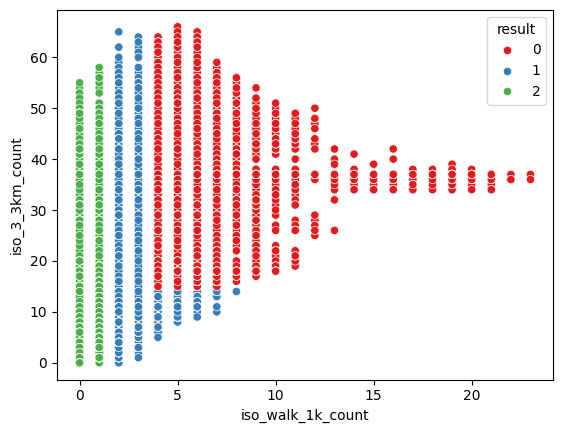

In [38]:
#
# Scatter plot with count of isochrone

sns.scatterplot(data=study_area, x='iso_walk_1k_count', y='iso_3_3km_count', hue='result', palette='Set1')

In [ ]:
# 2. Calculate the number of hospitals reachable within a 15-minute walk
foot_joined = gpd.sjoin(study_area, isochrones_foot_gdf, how="left", predicate="intersects")
foot_counts = foot_joined.groupby(foot_joined.index)["hcf_id"].nunique()
study_area["facilities_15min_walk"] = study_area.index.map(foot_counts).fillna(0).astype(int)

In [ ]:
# 3. Classify Access Deprivation Level
def classify_deprivation(drive, walk):
    if drive >= 5:
        return "0" # low deprivation
    elif walk <= 1:
        return "2" # high deprivation
    else:
        return "1" # medium deprivation

study_area["result"] = study_area.apply(
    lambda row: classify_deprivation(row["facilities_10min_drive"], row["facilities_15min_walk"]),
    axis=1
)